## Loading Phoenix

Functions to load in phoenix spectra.
To use in other notebooks.

In [6]:
from spectrum_overload import Spectrum

import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import numpy as np
from astropy.io import fits

from astro_scripts.plot_fits import get_wavelength, ccf_astro, vac2air
from PyAstronomy.pyasl.phoenixUtils.read import readUnit7, readDTable, decomposeFilename
%matplotlib inline

In [7]:
def load_phoenix_aces(fname):
    """
    Returns
    -------
    wavelength  (nanometers)
    flux        ('erg/s/cm^2/A' )
    
    """
    flux = fits.getdata(fname)
    wav = "data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits"
    return fits.getdata(wav) / 10, flux*1e-8

def get_DF(fname):
    """Specify the DF value for equation.
    
    DF= -8.d0 for all most recent models (Ergs/sec/cm**2/cm). For older model
    series like the NextGen and AMES-Cond grids DF= -26.9007901434d0, 
    because previous Phoenix outputs were giving out the luminosity, 
    L (= R**2 * H) in erg/s/cm**2/cm.  And for NextGen spectra
    of effective temperature 5000K and above, DF'= -28.9007901434d0.

    Note: Jason assumes there is a typo above and it is  /A instead of cm for Df=-8.
        To match the flux units for column 2."""

    if "AMES-Cond" in fname:
        DF = -26.9007901434
    else:
        DF = -8.0
        # print("DF = {0}".format(DF))
    return DF
    

def load_Allard_Phoenix(fname):
    """Load the Phoenix models from France Allard.
    
    Input
    -----
    fname: str
        Filename of Phoenix spectra.
        
    Returns
    -------
    wavelength          (nanometers)
    flux                (Ergs/sec/cm**2/A)
    black body flux     (Ergs/sec/cm**2/A)
    """

    DF = get_DF(fname)

    if fname.endswith(".7"):
        # Spectra are provided in an ascii format (*.7.gz):
        df = pd.read_table(fname, delim_whitespace=True, header=None, usecols=[0, 1, 2])
        df = df.astype(str)
        df[0] = df[0].str.replace("D", "E")
        df[1] = df[1].str.replace("D", "E")
        df[2] = df[2].str.replace("D", "E")
        df.columns = ["wavelength", "flux", "bb_flux"]
        df = df.astype(np.float64)

        # ***A very important point is that since models are often computed on parallel
        # computers using several nodes, it is important to sort the spectra files in
        # increasing wavelength order prior to using them.***
        df.sort_values(by="wavelength")
        
        # Cut db
        df = df[(df["wavelength"] > 3000) & (df["wavelength"] < 50000)]
        # column1: wavelength in Angstrom
        # column2: 10**(F_lam + DF) to convert to Ergs/sec/cm**2/A
        # column3: 10**(B_lam + DF) i.e. the blackbody fluxes of same Teff in same units.
        wavelength = df["wavelength"].values / 10  # to nanometers
        flux = 10 ** (df["flux"].values + DF)  # Ergs/sec/cm**2/A
        bb_flux = 10 ** (df["bb_flux"].values + DF)  # blackbody fluxes

    elif fname.endswith(".7"):
        # With the stacked ascii format (*.spec.gz files ) we have rather:
        # line1: Teff logg [M/H] of the model
        # line2: number of wavelengths
        # line3: F_lam(n) X 10**DF , n=1,number of wavelengths
        # lineX: B_lam(n) X 10**DF , n=1,number of wavelengths
        # This older file format is no longer used and no ID output is provided with those files.
        raise NotImplementedError
    elif fname.endswith("cf128.sc.spid.fits"):
        data = fits.getdata(fname)
        wavelength = data["wavelength"]
        flux = data["flux"]
        bb_flux = np.nan * np.ones_like(flux)        
    else:
        raise NotImplementedError("For spectra like {}".format(fname))
    
    index = wavelength.argsort()
    return wavelength[index], flux[index], bb_flux[index]


# files can also use readUnit7 from pyastronomy phoneix utils. 
# but they give result in /cm. not /Angstrom. (factor of 10**8 that comes from DF for new models)
def phoenix_readUnit7(fname):
    """Read in Phoenix using readUnit7 then separates out components.
    
    Returns
    -------
    wavelength      A
    flux            (Ergs/sec/cm**2/A)
    blackbody flux  (Ergs/sec/cm**2/A)
    """
    from PyAstronomy.pyasl.phoenixUtils.read import readUnit7
    if fname.endswith(".xz") or fname.endswith(".b2z"):
        raise("compression error, please unzip first.")
    
    result = readUnit7(fname)
    return result[:,0], result[:,1]*1e-8, result[:,2]*1e-8


def align2model(spectrum, model):
    """Doppler shift spectrum to Model, matched with ccf."""
    rv1, r_sun, c_sun, x_sun, y_sun = ccf_astro((spectrum.xaxis, -spectrum.flux + 1), (model.xaxis, -model.flux + 1))
    spectrum.doppler_shift(-rv1)
    return spectrum

As we are mostly interested in the NIR I will limit the synthetic models to 1000-3000nm. This removes many large differences at the blue optical end.

In [8]:
limits = [2000, 3000]

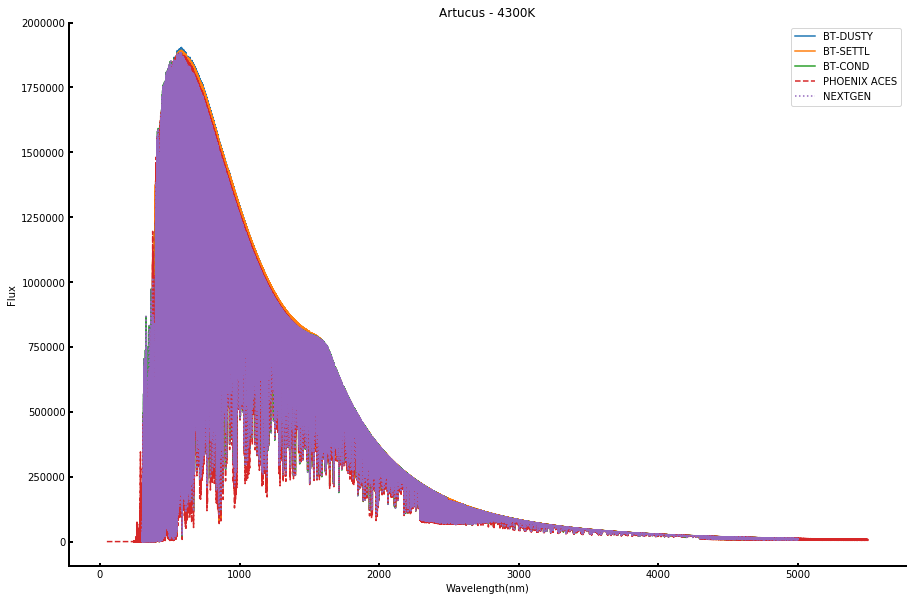

In [9]:
if __name__ == "__main__":
    # Simple test that they load
    w_settl, f_settl, bb_settl = load_Allard_Phoenix("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")

    w_dusty, f_dusty, bb_dusty = load_Allard_Phoenix("data/lte043-2.5-0.0.BT-Dusty.spec.7")

    w_next, f_next, bb_next = load_Allard_Phoenix("data/lte043-2.5-0.0a+0.0.BT-NextGen.7")

    w_cond, f_cond, bb_cond = load_Allard_Phoenix("data/lte043-2.5-0.0a+0.0.BT-Cond.7")

    w_aces, f_aces = load_phoenix_aces("data/lte04300-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
  
    # Full Spectrum
    plt.figure(figsize=(15, 10))
    plt.plot(w_dusty, f_dusty, label="BT-DUSTY")
    plt.plot(w_settl, f_settl, label="BT-SETTL")
    plt.plot(w_cond, f_cond, label="BT-COND")
    plt.plot(w_aces, f_aces, linestyle="--", label="PHOENIX ACES")
    plt.plot(w_next, f_next, linestyle=":", label="NEXTGEN")

    plt.title("Artucus - 4300K")
    plt.xlabel("Wavelength(nm)")
    plt.ylabel("Flux")
    plt.legend()
    plt.show()
    
    

In [5]:
# Test PyAstronomy loader function compared to mine.
# Commented out to not run on every loading.

# from PyAstronomy.pyasl.phoenixUtils.read import readUnit7

# %timeit x,y,z = load_Allard_Phoenix("data/lte043-2.5-0.0.BT-Dusty.spec.7")
# 3.03 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# %timeit x = readUnit7("data/lte043-2.5-0.0.BT-Dusty.spec.7")
# 2.41 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# %timeit x, y, z = phoenix_readUnit7("data/lte043-2.5-0.0.BT-Dusty.spec.7")
# 2.47 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# readUnit7 is faster.

